In [13]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [14]:
from functools import partial

import numpy
from matplotlib import pyplot, cm, colors, colorbar, animation

from pyioflash import SimulationData

In [15]:
axes  = ('i',            'j',            'k'           )
procs = {'i':         8, 'j':         8, 'k':         1}
sizes = {'i':      64*8, 'j':      32*8, 'k':         0}
simmx = {'i':       2.0, 'j':       1.0, 'k':         0}
simmn = {'i':       0.0, 'j':       0.0, 'k':         0}
param = {'i':      0.00, 'j':     0.990, 'k':         0}
stype = {'i': 'SG_UGRD', 'j': 'SG_TANH', 'k': 'SG_UGRD'}
guard = 1
n_dim = 2

In [16]:
def sg_ugrd(gr_coords, axes, gr_min, gr_max, gr_gIndexSize, gr_guard, gr_loGc, gr_hiGc, gr_blkCornerID,
            gr_coordsGlb, gr_axisMe):
    # calculate block cell coordinates
    # start with a uniform distribution of points [0,1]
    gr_delta = (gr_max - gr_min) / gr_gIndexSize
    halfDelta = gr_delta / 2.0
    j = gr_blkCornerID - gr_guard - 1

    # uniform grid
    l, c, r = 0, 1, 2
    for axis, (coords, gmin, gmax, delta, halfd, p, low, high, jj) in enumerate(zip(
        gr_coords, gr_min, gr_max, gr_delta, halfDelta, gr_par, gr_loGc, gr_hiGc, j)):
        if axis < n_dim and axis in axes:
            for i in range(low - 1, high):
                coords[l, i, 0] = gmin + jj * delta
                coords[c, i, 0] = gmin + jj * delta + halfd
                jj = jj + 1
                coords[r, i, 0] = gmin + jj * delta
                
    # calculate global cell coordinates
    if gr_axisMe == 0:
        j = j * 0
        for axis, (coords, gmin, gmax, delta, halfd, p, low, high, jj) in enumerate(zip(
            gr_coordsGlb, gr_min, gr_max, gr_delta, halfDelta, gr_par, [0, 0, 0], gr_gIndexSize, j)):
            if axis < n_dim and axis in axes:
                for i in range(low - 1, high): 
                    coords[l, i, 0] = gmin + jj * delta
                    coords[c, i, 0] = gmin + jj * delta + halfd
                    jj = jj + 1
                    coords[r, i, 0] = gmin + jj * delta                    

In [17]:
def sg_tanh(gr_par,
            gr_coords, axes, gr_min, gr_max, gr_gIndexSize, gr_guard, gr_loGc, gr_hiGc, gr_blkCornerID,
            gr_coordsGlb, gr_axisMe):
    # calculate block cell coordinates
    # start with a uniform distribution of points [0,1]
    gr_delta = 1.0 / gr_gIndexSize
    halfDelta = gr_delta / 2.0
    j = gr_blkCornerID - gr_guard - 1

    # transform uniform to stretched using y(s) = Tanh((-1+2s) atan(a)) + 1 / 2a
    l, c, r = 0, 1, 2
    for axis, (coords, gmin, gmax, delta, halfd, p, low, high, jj) in enumerate(zip(
        gr_coords, gr_min, gr_max, gr_delta, halfDelta, gr_par, gr_loGc, gr_hiGc, j)):
        if axis < n_dim and axis in axes:
            for i in range(low - 1, high):
                coords[l, i, 0] = (gmax - gmin) * (numpy.tanh((-1.0 + 2.0 * jj * delta        ) * numpy.arctanh(p)) / p + 1.0) / 2.0 + gmin
                coords[c, i, 0] = (gmax - gmin) * (numpy.tanh((-1.0 + 2.0 * jj * delta + halfd) * numpy.arctanh(p)) / p + 1.0) / 2.0 + gmin
                jj = jj + 1
                coords[r, i, 0] = (gmax - gmin) * (numpy.tanh((-1.0 + 2.0 * jj * delta        ) * numpy.arctanh(p)) / p + 1.0) / 2.0 + gmin

    # calculate global cell coordinates
    if gr_axisMe == 0:
        j = j * 0
        for axis, (coords, gmin, gmax, delta, halfd, p, low, high, jj) in enumerate(zip(
            gr_coordsGlb, gr_min, gr_max, gr_delta, halfDelta, gr_par, [0, 0, 0], gr_gIndexSize, j)):
            if axis < n_dim and axis in axes:
                for i in range(low - 1, high):
                    coords[l, i, 0] = (gmax - gmin) * (numpy.tanh((-1.0 + 2.0 * jj * delta        ) * numpy.arctanh(p)) / p + 1.0) / 2.0 + gmin
                    coords[c, i, 0] = (gmax - gmin) * (numpy.tanh((-1.0 + 2.0 * jj * delta + halfd) * numpy.arctanh(p)) / p + 1.0) / 2.0 + gmin
                    jj = jj + 1
                    coords[r, i, 0] = (gmax - gmin) * (numpy.tanh((-1.0 + 2.0 * jj * delta        ) * numpy.arctanh(p)) / p + 1.0) / 2.0 + gmin        

In [18]:
# create grid parameters as in GRID/UG/RegularGrid
gr_guard = numpy.ones(len(axes), int) * guard
gr_axisNumProcs = numpy.array(list(procs.values()), int)
gr_gIndexSize = numpy.array(list(sizes.values()), int) 
gr_min = numpy.array(list(simmn.values()), float)
gr_max = numpy.array(list(simmx.values()), float)
gr_par = numpy.array(list(param.values()), float)

In [19]:
# Create mapping for apply grid routines
map_axes = lambda stretch: [axis for axis, method in enumerate(stype.values()) if method == stretch]
any_axes = lambda stretch: len(map_axes(stretch)) > 0
stretching = {'SG_UGRD': sg_ugrd,
              'SG_TANH': partial(sg_tanh, gr_par)
             }

In [20]:
# Create processor mesh comm like in FLASH4
np = gr_axisNumProcs
mesh = [[k*np[1]*np[0]+j*np[0]+i, [i, j, k]] for k in range(np[2]) for j in range(np[1]) for i in range(np[0])]

# Create grids
coords, coordsGlb = [], []
for gr_meshMe, gr_axisMe in mesh:
    #store local index size for each block
    gr_lIndexSize = numpy.array(gr_gIndexSize / gr_axisNumProcs, int)

    #store lower left global index for each dim
    gr_blkCornerID = gr_axisMe * gr_lIndexSize + 1 

    gr_loGc = numpy.ones(len(axes), int) * 1
    gr_lo = gr_loGc + gr_guard
    gr_hi = gr_lo + gr_lIndexSize - 1
    gr_hiGc = gr_hi + gr_guard

    for axis in range(n_dim, len(axes)):
        gr_loGc[axis] = 1
        gr_lo[axis] = 1
        gr_hi[axis] = 1
        gr_hiGc[axis] = 1 
        gr_guard[axis] = 0
        gr_gIndexSize[axis] = 1

    # Now create the grid and coordinates etc
    gr_coords = [numpy.zeros((3, high - low + 1, 1)) for high, low in zip(gr_hiGc, gr_loGc)]
    gr_coordsGlb = [numpy.zeros((3, high, 1)) for high in gr_gIndexSize]

    for method, func in stretching.items():
        if any_axes(method):
            func(gr_coords, map_axes(method), gr_min, gr_max, gr_gIndexSize, gr_guard, gr_loGc, gr_hiGc, gr_blkCornerID,
                 gr_coordsGlb, gr_axisMe)
            
    coords.append(gr_coords)
    coordsGlb.append(gr_coordsGlb)
    
gr_iCoords, gr_jCoords, gr_kCoords = [numpy.array([[block[n][f, :, 0] for block in coords] for f in range(3)]) for n in range(3)]
gr_iCoordsGlb, gr_jCoordsGlb, gr_kCoordsGlb = [numpy.array([[block[n][f, :, 0] for block in coordsGlb] for f in range(3)]) for n in range(3)]

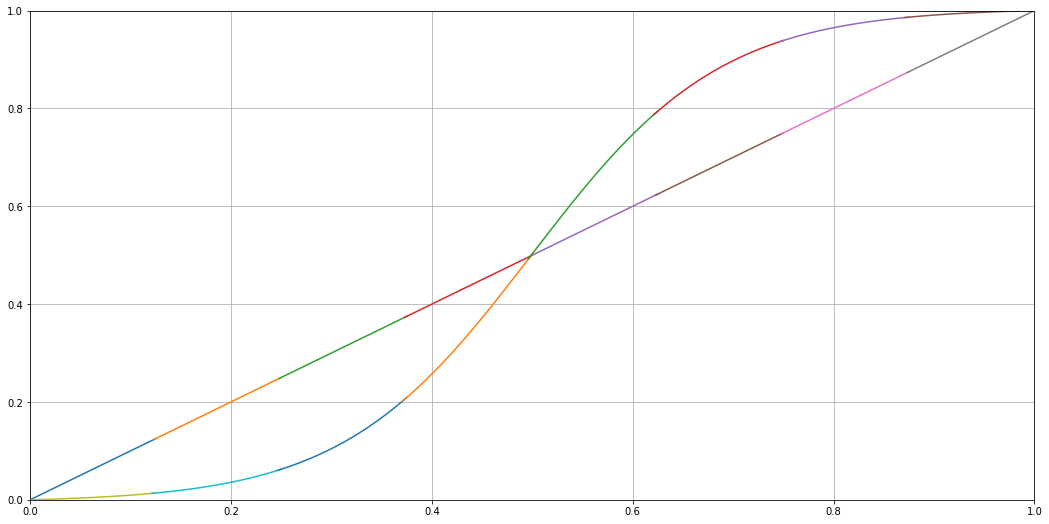

In [21]:
fig, ax = pyplot.subplots(figsize=(18, 9))

for block, coord in enumerate(coords[0:8]):
    z = coord[0][0, :, 0]
    lz = len(z)
    x = numpy.linspace(block*(lz-2*gr_guard[0])-1, (block+1)*(lz-2*gr_guard[0])+1, lz, False)
    pyplot.plot(x / gr_gIndexSize[0], z / gr_max[0])
    
for block, coord in enumerate(coords[::8]):
    z = coord[1][1, :, 0]
    lz = len(z)
    x = numpy.linspace(block*(lz-2*gr_guard[1])-1, (block+1)*(lz-2*gr_guard[1])+1, lz, False)
    pyplot.plot(x / gr_gIndexSize[1], z / gr_max[1])
    
pyplot.xlim((0, 1))
pyplot.ylim((0, 1));
pyplot.grid(True, which='both')

In [22]:
outpath = ""#"ra08_steady/"

ini_name = 'INS_Rayleigh_'
header = 'hdf5_plt_cnt_'

data = SimulationData.from_list([600], path="ra08_steady/", basename='INS_Rayleigh_', header="hdf5_plt_cnt_")
lowdata = data.geometry
lowvals = data.fields
del[data]


############    Building SImulationData Object   ############

Processing metadata from: ra08_steady/INS_Rayleigh_hdf5_plt_cnt_0600
Reading Grid from File
Processing file: ra08_steady/INS_Rayleigh_hdf5_plt_cnt_0600

#############################################################


